<a href="https://colab.research.google.com/github/chhhhr/Medical-insurance-fraud-Intelligent-monitoring-research/blob/main/2_edition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

根据《全国基本医疗保险欺诈行为
智能监测研究》这篇论文，列出以下几点医疗保险欺诈行为识别中的关键点


1. 数据预处理  
  *   缺失值
  *   异常值（有哪些情况会被判定为异常值）
  *   参保人员数据合并
  *   重抽样（Kmeans聚类算法欠采样，SMOTE过采样）

2. 特征工程
  *   长期维度和短期维度
  *   方差筛选（直方图）
  *   peasion相关系数筛选
  *   lasso回归系数筛选（等于0的去除）
  *   正常用户和欺诈用户指标对比
3. 模型构建
  *   随机森林
  *   梯度提升树
  *   其他算法
4. 模型评估
  *   评估指标（Roc，Auc，准确率，精确率，召回率，f值）
  *   召回率优先
5. 模型优化
  *   模型组合



## 导入库和原始数据

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

origin_data = pd.read_csv('data.csv')
features = origin_data.columns

In [41]:
# 下载字体
!wget -O /usr/share/fonts/truetype/liberation/simhei.ttf "https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf"

import matplotlib as mpl
zhfont = mpl.font_manager.FontProperties(fname='/usr/share/fonts/truetype/liberation/simhei.ttf')

--2024-04-09 07:54:47--  https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf
Resolving www.wfonts.com (www.wfonts.com)... 104.21.1.127, 172.67.129.58, 2606:4700:3031::ac43:813a, ...
Connecting to www.wfonts.com (www.wfonts.com)|104.21.1.127|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10050870 (9.6M) [application/octetstream]
Saving to: ‘/usr/share/fonts/truetype/liberation/simhei.ttf’

/usr/share/fonts/tr 100%[===================>]   9.58M  17.0MB/s    in 0.6s    

2024-04-09 07:54:48 (17.0 MB/s) - ‘/usr/share/fonts/truetype/liberation/simhei.ttf’ saved [10050870/10050870]



## 查看原始数据

In [5]:
origin_data.describe()

,个人编码,一天去两家医院的天数,就诊的月数,月就诊天数_MAX,月就诊天数_AVG,月就诊医院数_MAX,月就诊医院数_AVG,就诊次数_SUM,月就诊次数_MAX,月就诊次数_AVG,月统筹金额_MAX,月统筹金额_AVG,月药品金额_MAX,月药品金额_AVG,医院_就诊天数_MAX,医院_就诊天数_AVG,医院_统筹金_MAX,医院_统筹金_AVG,医院_药品_MAX,医院_药品_AVG,医院编码_NN,顺序号_NN,交易时间DD_NN,交易时间YYYY_NN,交易时间YYYYMM_NN,住院天数_SUM,个人账户金额_SUM,统筹支付金额_SUM,ALL_SUM,可用账户报销金额_SUM,药品费发生金额_SUM,药品费自费金额_SUM,药品费申报金额_SUM,贵重药品发生金额_SUM,中成药费发生金额_SUM,中草药费发生金额_SUM,检查费发生金额_SUM,检查费自费金额_SUM,检查费申报金额_SUM,贵重检查费金额_SUM,治疗费发生金额_SUM,治疗费自费金额_SUM,治疗费申报金额_SUM,手术费发生金额_SUM,手术费自费金额_SUM,手术费申报金额_SUM,床位费发生金额_SUM,床位费申报金额_SUM,医用材料发生金额_SUM,高价材料发生金额_SUM,医用材料费自费金额_SUM,成分输血申报金额_SUM,其它发生金额_SUM,其它申报金额_SUM,一次性医用材料申报金额_SUM,起付线标准金额_MAX,起付标准以上自负比例金额_SUM,医疗救助个人按比例负担金额_SUM,最高限额以上金额_SUM,基本统筹基金支付金额_SUM,公务员医疗补助基金支付金额_SUM,城乡救助补助金额_SUM,基本个人账户支付_SUM,非账户支付金额_SUM,本次审批金额_SUM,补助审批金额_SUM,医疗救助医院申请_SUM,残疾军人补助_SUM,民政救助补助_SUM,城乡优抚补助_SUM,出院诊断病种名称_NN,出院诊断LENTH_MAX,药品在总金额中的占比,个人支付的药品占比,检查总费用在总金额占比,个人支付检查费用占比,治疗费用在总金额占比,个人支付治疗费用占比,BZ_民政救助,BZ_城乡优抚,是否挂号,RES
count,5.351000e+03,5351.00000,5351.000000,5351.000000,5351.000000,5351.000000,5351.000000,5351.000000,5351.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.0,5350.000000,5350.0,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.00000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.0,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5244.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000
mean,3.520000e+14,1.95384,5.835732,7.746403,5.773907,2.149879,1.775507,36.495795,8.354513,6.198676,3794.567039,2675.797290,3585.161628,2567.402132,25.766355,18.207011,11859.469518,8285.279532,11304.508419,7800.875615,2.253645,89.827664,34.001495,1.0,5.835701,0.0,2197.282723,15705.194336,17835.953050,2081.160452,15107.545108,83.486086,14877.027778,2402.92277,3489.075807,2439.424791,565.745578,9.104419,551.320579,45.596636,1860.410267,8.180931,1836.456776,3.556822,0.070093,3.486729,5.611589,5.580935,285.842243,1.889411,7.999127,14.400374,7.241443,0.023738,252.496105,6.998731,2148.412378,63.871744,0.0,15095.283007,2.904163,302.672768,105.638845,2091.643879,17545.431581,476.280357,255.679314,2.352321,301.822594,0.159482,5.425421,26.609649,0.865702,0.005762,0.037511,0.004997,0.071704,0.010383,0.141308,0.000187,0.262991,0.044860
std,0.000000e+00,5.21055,0.662000,4.031021,3.183137,0.955632,0.739600,22.490187,5.031982,3.768782,2705.216874,1648.980584,2530.817083,1661.006474,15.950451,12.253166,7991.726590,6507.995230,7581.484149,5630.241940,1.063229,60.603124,19.151266,0.0,0.662058,0.0,2281.975269,9653.877504,12007.492648,2231.239191,9880.479898,169.363077,9619.465420,5393.98591,3558.164649,3372.468843,852.228985,92.655045,808.478365,253.286008,5685.279747,85.972521,5588.995762,82.516594,4.126861,82.385499,30.484461,30.467124,330.795195,55.094910,66.056355,642.726860,26.887656,1.392095,309.751626,112.239653,2014.831438,810.683351,0.0,8446.196209,151.312649,1267.028739,157.781133,2279.594253,11695.529288,1822.245254,3242.753757,146.763218,1262.654506,11.665120,2.840949,12.421241,0.148991,0.012859,0.060698,0.032804,0.132462,0.054314,0.348372,0.013672,0.440299,0.207016
min,3.520000e+14,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,1.000000,1.0,1.000000,0.0,7.000000,0.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

In [6]:
origin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5351 entries, 0 to 5350
Data columns (total 82 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   个人编码               5351 non-null   float64
 1   一天去两家医院的天数         5351 non-null   int64  
 2   就诊的月数              5351 non-null   int64  
 3   月就诊天数_MAX          5351 non-null   int64  
 4   月就诊天数_AVG          5351 non-null   float64
 5   月就诊医院数_MAX         5351 non-null   int64  
 6   月就诊医院数_AVG         5351 non-null   float64
 7   就诊次数_SUM           5351 non-null   int64  
 8   月就诊次数_MAX          5351 non-null   int64  
 9   月就诊次数_AVG          5350 non-null   float64
 10  月统筹金额_MAX          5350 non-null   float64
 11  月统筹金额_AVG          5350 non-null   float64
 12  月药品金额_MAX          5350 non-null   float64
 13  月药品金额_AVG          5350 non-null   float64
 14  医院_就诊天数_MAX        5350 non-null   float64
 15  医院_就诊天数_AVG        5350 non-null   float64
 16  医院_统筹金_MAX         5350 

In [7]:
origin_data.head(10)

,个人编码,一天去两家医院的天数,就诊的月数,月就诊天数_MAX,月就诊天数_AVG,月就诊医院数_MAX,月就诊医院数_AVG,就诊次数_SUM,月就诊次数_MAX,月就诊次数_AVG,月统筹金额_MAX,月统筹金额_AVG,月药品金额_MAX,月药品金额_AVG,医院_就诊天数_MAX,医院_就诊天数_AVG,医院_统筹金_MAX,医院_统筹金_AVG,医院_药品_MAX,医院_药品_AVG,医院编码_NN,顺序号_NN,交易时间DD_NN,交易时间YYYY_NN,交易时间YYYYMM_NN,住院天数_SUM,个人账户金额_SUM,统筹支付金额_SUM,ALL_SUM,可用账户报销金额_SUM,药品费发生金额_SUM,药品费自费金额_SUM,药品费申报金额_SUM,贵重药品发生金额_SUM,中成药费发生金额_SUM,中草药费发生金额_SUM,检查费发生金额_SUM,检查费自费金额_SUM,检查费申报金额_SUM,贵重检查费金额_SUM,治疗费发生金额_SUM,治疗费自费金额_SUM,治疗费申报金额_SUM,手术费发生金额_SUM,手术费自费金额_SUM,手术费申报金额_SUM,床位费发生金额_SUM,床位费申报金额_SUM,医用材料发生金额_SUM,高价材料发生金额_SUM,医用材料费自费金额_SUM,成分输血申报金额_SUM,其它发生金额_SUM,其它申报金额_SUM,一次性医用材料申报金额_SUM,起付线标准金额_MAX,起付标准以上自负比例金额_SUM,医疗救助个人按比例负担金额_SUM,最高限额以上金额_SUM,基本统筹基金支付金额_SUM,公务员医疗补助基金支付金额_SUM,城乡救助补助金额_SUM,基本个人账户支付_SUM,非账户支付金额_SUM,本次审批金额_SUM,补助审批金额_SUM,医疗救助医院申请_SUM,残疾军人补助_SUM,民政救助补助_SUM,城乡优抚补助_SUM,出院诊断病种名称_NN,出院诊断LENTH_MAX,药品在总金额中的占比,个人支付的药品占比,检查总费用在总金额占比,个人支付检查费用占比,治疗费用在总金额占比,个人支付治疗费用占比,BZ_民政救助,BZ_城乡优抚,是否挂号,RES
0,3.520000e+14,0,6,7,5.666667,3,2.166667,34,7,5.666667,3501.18,2541.293333,3901.45,2695.291667,20.0,11.333333,7553.00,5082.586667,8522.57,5390.583333,3.0,69.0,34.0,1.0,6.0,0.0,1970.99,15247.76,17218.75,1868.06,16171.75,68.93,15929.04,1984.60,4776.49,0.00,875.0,0.0,875.0,0.0,128.0,0.0,128.0,0.0,0.0,0.0,0.0,0.0,10.00,0.0,0.0,0.0,34.0,0.0,10.00,0.0,1694.28,0.0,0.0,15247.76,0.0,0.00,228.80,1742.19,16942.04,0.00,0.0,0.0,0.00,0.0,4.0,29.0,0.939194,0.004262,0.050817,0.0,0.007434,0.000000,0.0,0.0,1.0,0.0
1,3.520000e+14,0,6,4,2.500000,2,1.333333,15,4,2.500000,2217.66,1637.358333,2449.13,1783.153333,13.0,7.500000,9500.07,4912.075000,10309.64,5349.460000,2.0,64.0,15.0,1.0,6.0,0.0,1371.57,9824.15,11195.72,1339.67,10698.92,31.90,10418.95,2264.73,1132.45,0.00,345.0,0.0,345.0,0.0,150.0,0.0,150.0,0.0,0.0,0.0,0.0,0.0,1.80,0.0,0.0,0.0,0.0,0.0,1.80,0.0,1091.60,0.0,0.0,9824.15,0.0,0.00,199.50,1172.07,10915.75,0.00,0.0,0.0,0.00,0.0,3.0,20.0,0.955626,0.002982,0.030815,0.0,0.013398,0.000000,0.0,0.0,1.0,0.0
2,3.520000e+14,8,6,8,6.166667,3,2.166667,45,9,7.500000,3360.55,2583.053333,3302.06,2368.528333,23.0,15.000000,9161.73,5166.106667,10760.51,4737.056667,3.0,102.0,37.0,1.0,6.0,0.0,2637.20,15498.32,18135.52,2621.28,14211.17,4.72,13926.88,0.00,3762.15,0.00,0.0,0.0,0.0,0.0,3538.0,0.0,3538.0,0.0,0.0,0.0,75.0,75.0,300.15,0.0,0.0,0.0,11.2,0.0,300.15,0.0,2341.71,0.0,0.0,15498.32,0.0,0.00,234.00,2403.20,17840.03,0.00,0.0,0.0,0.00,0.0,4.0,29.0,0.783610,0.000332,0.000000,0.0,0.195087,0.000000,0.0,0.0,0.0,0.0
3,3.520000e+14,0,6,6,3.666667,2,1.833333,23,6,3.833333,3030.61,2057.720000,1500.12,1048.730000,17.0,11.500000,11622.17,6173.160000,5504.60,3146.190000,2.0,56.0,22.0,1.0,6.0,0.0,1373.06,12346.32,13719.38,1371.90,6292.38,1.16,6291.22,0.00,5075.85,0.00,0.0,0.0,0.0,0.0,7427.0,0.0,7427.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1371.90,0.0,0.0,12346.32,0.0,0.00,73.34,1299.72,13718.22,0.00,0.0,0.0,0.00,0.0,5.0,16.0,0.458649,0.000184,0.000000,0.0,0.541351,0.000000,0.0,0.0,0.0,0.0
4,3.520000e+14,0,6,5,4.333333,1,1.000000,26,5,4.333333,2332.45,2196.315000,2563.26,2417.923333,26.0,26.000000,13177.89,13177.890000,14507.54,14507.540000,1.0,64.0,26.0,1.0,6.0,0.0,1569.65,13177.89,14747.54,1565.06,14507.54,4.59,14402.13,2367.68,3678.72,0.00,0.0,0.0,0.0,0.0,240.0,0.0,240.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1464.24,0.0,0.0,13177.89,0.0,0.00,64.00,1505.65,14642.13,0.00,0.0,0.0,0.00,0.0,2.0,33.0,0.983726,0.000316,0.000000,0.0,0.016274,0.000000,0.0,0.0,0.0,0.0
5,3.520000e+14,9,6,7,5.833333,4,3.000000,44,9,7.333333,3315.78,2727.961667,3525.46,2832.700000,26.0,11.000000,11837.15,4091.942500,12093.79,4249.050000,4.0,118.0,35.0,1.0,6.0,0.0,1959.43,16367.77,18327.20,1929.89,16996.20,4.74,16880.27,0.00,3754.24,583.09,409.0,0.0,409.0,0.0,591.5,0.0,591.5,0.0,0.0,0.0,0.0,0.0,330.50,0.0,24.8,0.0,0.0,0.0,305.70,0.0,1818.70,0.0,0.0,16367.77,0.0,0.00,144.00,1815.43,18186.47,0.00,0.0,0.0,0.00,0.0,9.0,30.0,0.927376,0.000279,0.022317,0.0,0.032274,0.000000,0.0,0.0,0.0,0.0
6,3.520000e+14,0,6,10,8.333333,4,2.833333,51,10,8.500000,4865.30,4142.551667,

## 数据分析

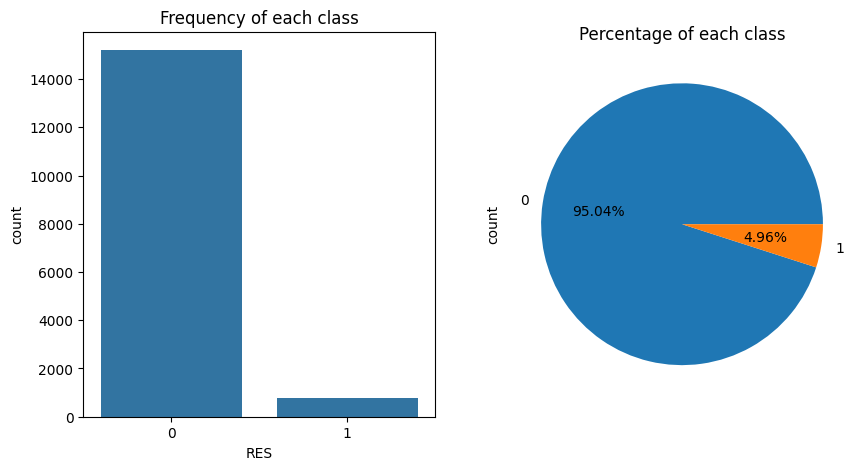

In [ ]:
# 查看正负样本比例
fig, axs = plt.subplots(1, 2, figsize=(10,5))
sns.countplot(x='RES', data=origin_data, ax=axs[0])
axs[0].set_title('Frequency of each class')
origin_data['RES'].value_counts().plot(x=None, y=None, kind='pie', ax=axs[1], autopct='%1.2f%%')
axs[1].set_title('Percentage of each class')
plt.show()

## 数据标准化

In [9]:
#采用z标准归一化
from sklearn.preprocessing import StandardScaler

data = origin_data
scaler = StandardScaler()
data_standardized = scaler.fit_transform(data[[col for col in data.columns if col != 'RES']])
data_standardized = pd.DataFrame(data_standardized, columns=[col for col in data.columns if col != 'RES'])
data_standardized['RES'] = data['RES']
data = data_standardized
data.describe()


,个人编码,一天去两家医院的天数,就诊的月数,月就诊天数_MAX,月就诊天数_AVG,月就诊医院数_MAX,月就诊医院数_AVG,就诊次数_SUM,月就诊次数_MAX,月就诊次数_AVG,月统筹金额_MAX,月统筹金额_AVG,月药品金额_MAX,月药品金额_AVG,医院_就诊天数_MAX,医院_就诊天数_AVG,医院_统筹金_MAX,医院_统筹金_AVG,医院_药品_MAX,医院_药品_AVG,医院编码_NN,顺序号_NN,交易时间DD_NN,交易时间YYYY_NN,交易时间YYYYMM_NN,住院天数_SUM,个人账户金额_SUM,统筹支付金额_SUM,ALL_SUM,可用账户报销金额_SUM,药品费发生金额_SUM,药品费自费金额_SUM,药品费申报金额_SUM,贵重药品发生金额_SUM,中成药费发生金额_SUM,中草药费发生金额_SUM,检查费发生金额_SUM,检查费自费金额_SUM,检查费申报金额_SUM,贵重检查费金额_SUM,治疗费发生金额_SUM,治疗费自费金额_SUM,治疗费申报金额_SUM,手术费发生金额_SUM,手术费自费金额_SUM,手术费申报金额_SUM,床位费发生金额_SUM,床位费申报金额_SUM,医用材料发生金额_SUM,高价材料发生金额_SUM,医用材料费自费金额_SUM,成分输血申报金额_SUM,其它发生金额_SUM,其它申报金额_SUM,一次性医用材料申报金额_SUM,起付线标准金额_MAX,起付标准以上自负比例金额_SUM,医疗救助个人按比例负担金额_SUM,最高限额以上金额_SUM,基本统筹基金支付金额_SUM,公务员医疗补助基金支付金额_SUM,城乡救助补助金额_SUM,基本个人账户支付_SUM,非账户支付金额_SUM,本次审批金额_SUM,补助审批金额_SUM,医疗救助医院申请_SUM,残疾军人补助_SUM,民政救助补助_SUM,城乡优抚补助_SUM,出院诊断病种名称_NN,出院诊断LENTH_MAX,药品在总金额中的占比,个人支付的药品占比,检查总费用在总金额占比,个人支付检查费用占比,治疗费用在总金额占比,个人支付治疗费用占比,BZ_民政救助,BZ_城乡优抚,是否挂号,RES
count,5351.0,5.351000e+03,5.351000e+03,5.351000e+03,5.351000e+03,5.351000e+03,5.351000e+03,5.351000e+03,5.351000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5350.0,5.350000e+03,5350.0,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5350.000000,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5350.0,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.244000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5350.000000,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5350.000000
mean,0.0,6.240985e-17,2.748689e-16,3.983607e-17,-1.776025e-16,1.341148e-16,4.408525e-16,8.697542e-17,3.585246e-17,7.570268e-17,-5.843716e-17,6.972616e-17,-3.121076e-17,9.263618e-17,-7.171833e-17,-1.460929e-17,-1.009369e-16,9.031197e-17,6.972616e-17,1.925770e-16,-1.514054e-16,-1.460929e-17,9.296821e-17,0.0,6.534337e-16,0.0,-7.703080e-17,2.523423e-17,-1.235149e-16,2.789046e-17,1.235149e-16,2.124988e-17,1.029291e-16,1.992176e-18,3.419902e-17,-9.562444e-17,-2.921858e-17,-8.632762e-18,-2.124988e-17,-3.851540e-17,1.062494e-17,2.257799e-17,-1.062494e-17,2.656235e-18,-3.984352e-18,-2.656235e-18,1.062494e-17,0.000000,1.328117e-17,-1.128900e-17,-4.316381e-18,9.296821e-18,7.968704e-18,2.656235e-18,-1.328117e-18,-1.660147e-17,-1.035931e-16,1.726552e-17,0.0,-1.879286e-16,5.976528e-18,-1.527335e-17,-7.171833e-17,-4.914034e-17,7.304645e-17,-3.453105e-17,5.312469e-18,1.328117e-18,1.195306e-17,-1.460929e-17,7.968704e-17,2.709927e-17,7.968704e-17,2.124988e-17,-3.187481e-17,-2.124988e-17,0.000000,-1.593741e-17,-6.308557e-18,-1.195306e-17,-7.968704e-18,0.044860
std,0.0,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,0.0,1.000093e+00,0.0,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,0.0,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000095e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093,1.00009

## 方差筛选

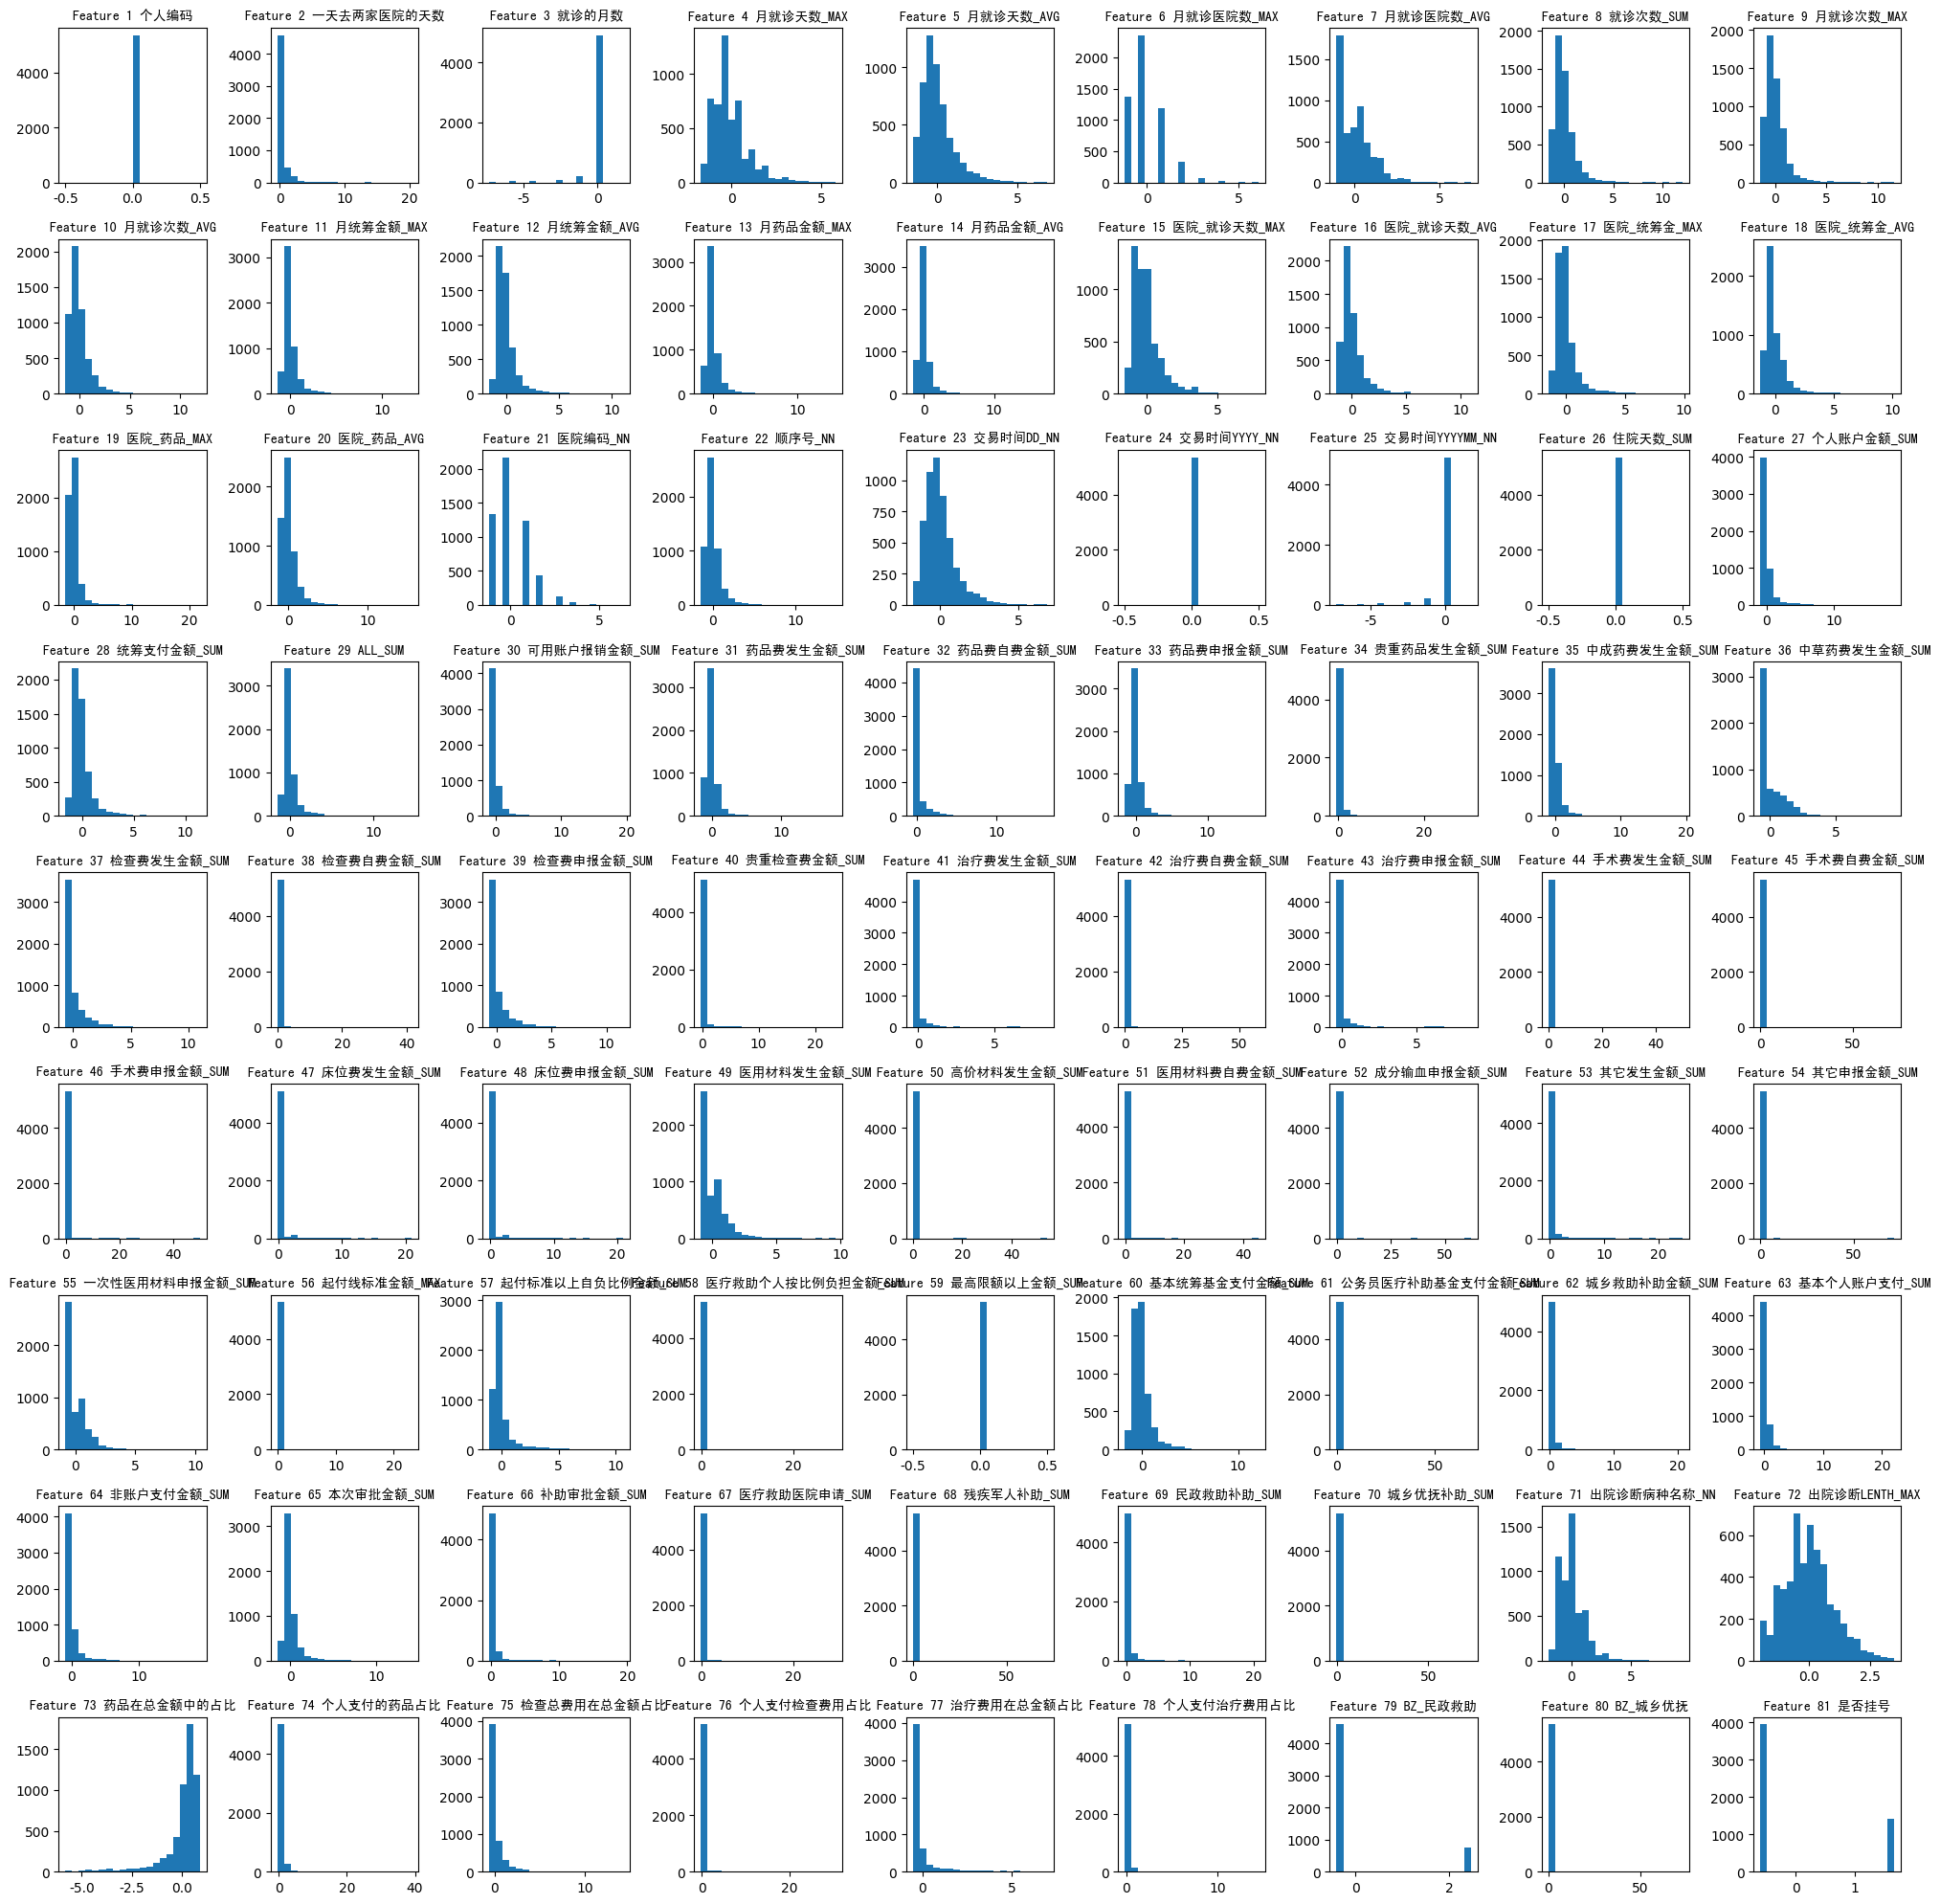

In [48]:
# 创建一个包含80个子图的画布
fig, axs = plt.subplots(9, 9, figsize=(20, 20))

# 在每个子图中画直方图
for i in range(9):
    for j in range(9):
        axs[i, j].hist(data.iloc[:, i * 9 + j], bins=20)
        axs[i, j].set_title(f'Feature {i * 9 + j + 1} {data.columns[i * 9 + j]}', fontproperties=zhfont)

# 调整子图之间的间距
plt.tight_layout()
plt.show()
# 需要删除的特征[1,24,26,38,42]

## 去除部分特征

In [ ]:
# data = origin_data.drop(columns=['出院诊断LENTH_MAX','交易时间YYYY_NN','住院天数_SUM'])
# features = data.columns
# print("Columns num after drop: {}".format(len(data.columns)))

Columns num after drop: 79


## 方差筛选

## 模型训练

In [ ]:
#划分数据集
from sklearn.model_selection import train_test_split

data_target = data['RES']
data_features = data[[x for x in data.columns if x != 'RES']]

# 测试集大小20%，训练集大小80%
x_train, x_test, y_train, y_test = train_test_split(data_features, data_target, test_size=0.2, random_state=2020)


In [ ]:
# 导入模型
from xgboost.sklearn import XGBClassifier

clf = XGBClassifier()

clf.fit(x_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## 模型预测

In [ ]:
train_predict = clf.predict(x_train)
test_predict = clf.predict(x_test)


## 模型评估

In [ ]:
from sklearn import metrics

# 查看混淆矩阵
confusion_matrix_result = metrics.confusion_matrix(test_predict, y_test)
print('The confusion matrix result:\n', confusion_matrix_result)


The confusion matrix result:
 [[3001  100]
 [  27   72]]
